In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import pickle

In [5]:
def fProcesamiento (df):
    df = df.copy()
    #Pongo el id sobre day para hacerle bypass a los outliers:
    df.day=df.id.apply(lambda x: x%365+1)
    
    #Columnas sacadas a partir de exploracion visual:
    df["rainperiod"] = df["day"].apply(lambda x: 1 if (x>=85 and x<=140) else 0)
    df["cloud75"] = df["cloud"].apply(lambda x: 1 if x >=75 else 0)
    
    #Columnas relacionadas con cloud:
    df["cloudxhumidity"] = df["cloud"] * df["humidity"]
    df["cloud_sun"] = df["cloud"] + df["sunshine"]
    df["cloudxhumidity_sun"] = df["cloud"] * df["humidity"] + df["sunshine"]
    df["cloud_windspeed"] = df["cloud"] + df["windspeed"]
    df["cloud_temperature"] = df["cloud"] + df["temparature"]

    #Columnas relacionadas con el tiempo:
    df["day_sen"] = np.sin(2 * np.pi * df["day"]/365)
    df["day_cos"] = np.cos(2 * np.pi * df["day"]/365)

    #Columnas random:
    df["humidity_dewpoint"] = df["humidity"] + df["dewpoint"]
    df["humidity_mintemp"] = df["humidity"] + df["mintemp"]
    df["dewpoint_mintemp"] = df["dewpoint"] + df["mintemp"]
    df["windtot"] = df["windspeed"]*df["winddirection"]

    #Ultimas adiciones:
    df["humidity5"] = df["humidity"].shift(5)
    df["sun"] = pd.cut(df["sunshine"], bins=3, labels=["Bajo","Medio", "Alto"])
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[['sun']])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sun']))
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns="sun")
    #Tratamiento de los nan:
    df = df.fillna(df.mean())
    
    #Columnas seleccionadas para el dataframe final:
    x = df.drop(columns=["id","maxtemp","mintemp"])

    return x

In [8]:
df = fProcesamiento(pd.read_csv("train.csv"))

In [10]:
X = df.drop(columns="rainfall")
y = df["rainfall"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

smote = SMOTE(random_state=42) #NO es aconsejable cuando hay temporalidad. De todas formas, si se hace puede dar un boost si los datos generados en kaggle son sintéticos.
#Si se hace, hacedlo siempre sobre el train y no en el test.
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [11]:
rf = RandomForestClassifier()

In [19]:
param_grid = {
 'max_features': [0.33,"sqrt"],
    "max_depth": [3,4,5],
 'min_samples_leaf': [15,16,17,18,19,20],
 'min_samples_split': [5,6,7,8,9,10],
 'n_estimators': [100],
 'verbose': [0],}
clf = GridSearchCV(rf, param_grid,n_jobs=4,cv=4,verbose=2)
clf.fit(X_train_res, y_train_res)
clf.best_params_

Fitting 4 folds for each of 216 candidates, totalling 864 fits


C:\Users\Acer\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'n_estimators': 100,
 'verbose': 0}

In [30]:
rf = RandomForestClassifier(max_depth=5, max_features= "sqrt", min_samples_leaf= 15, min_samples_split= 5, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                       random_state=42)

In [32]:
#Test values RF
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.886208304969367


<Figure size 1000x800 with 0 Axes>

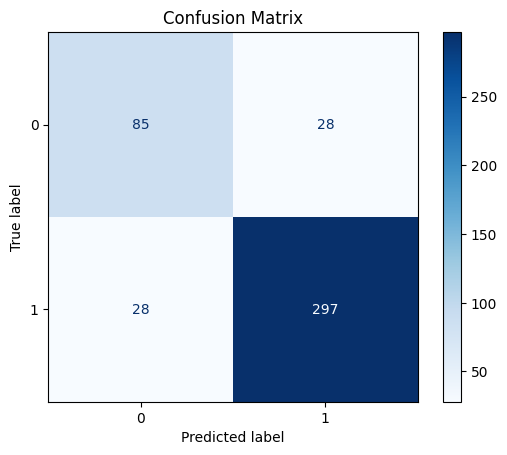

In [58]:
y_pred = rf.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Método 1: Visualización con Matplotlib usando ConfusionMatrixDisplay
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       113
           1       0.91      0.89      0.90       325

    accuracy                           0.85       438
   macro avg       0.80      0.81      0.80       438
weighted avg       0.85      0.85      0.85       438



Cargo todos los valores del dataset de test

In [42]:
X_res, y_res = smote.fit_resample(X, y)
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                       random_state=42)

Genero nuevas predicciones para hacer submission en Kaggle

In [44]:
test = pd.read_csv("test.csv")
test.loc[test.winddirection.isna(),"winddirection"]=test.winddirection.mean()
test = fProcesamiento(test)
y_pred_submission_rf = rf.predict_proba(test)[:,1]
submission_rf=pd.read_csv("sample_submission.csv")
submission_rf.rainfall = y_pred_submission_rf
submission_rf.to_csv("submission_rf.csv", index = False)

In [46]:
submission_rf

,id,rainfall
0,2190,0.967220
1,2191,0.977083
2,2192,0.833504
3,2193,0.118743
4,2194,0.057271
...,...,...
725,2915,0.952699
726,2916,0.602728
727,2917,0.940686
728,2918,0.976347


In [56]:
# Guardo el modelo en .pkl
with open('rainfall_rf.pkl', 'wb') as file:
    pickle.dump(rf, file)
print("Model saved as .pkl file successfully!")

Model saved as .pkl file successfully!
